In [1]:
import subprocess
import os
import ete3
import random
import numpy as np
from Bio import SeqIO
import pandas as pd
import multiprocessing
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import random
from scipy.stats import spearmanr, linregress

#
# initial definitions
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

%cd /work/site_rate/sequence_simulation/hug/dayhoff
%matplotlib inline

tree = ete3.Tree('../reference.tre')

/work/site_rate/sequence_simulation/hug/dayhoff


In [ ]:
#
# parse rates classification
#
if not os.path.isdir('categories'):
    os.mkdir('categories')
else:
    os.system('rm -r categories/*')

for replicate in range(1, 101):
    alignment = list(SeqIO.parse('../%i.fas' % replicate, 'fasta'))

    rates = pd.read_table('%i.rate' % replicate, comment='#')
    for category in rates.Cat.unique():
        site_df        = rates[rates.Cat == category]
        category_aln   = {sequence.name:'' for sequence in alignment}
        for sequence in alignment:
            category_aln[sequence.name] = ''.join([sequence[position] for position in site_df.index])

        out = open('categories/%i.%i.aln' % (replicate, category), 'w')
        for header, sequence in category_aln.items():
            full_sequence = ''
            while len(full_sequence) <= 5000:
                full_sequence += sequence
            out.write('>%s\n%s\n' % (header, full_sequence[:5000]))
        out.close()

In [3]:
%cd /work/site_rate/sequence_simulation/hug
bipartitions   = []
branch_lengths = []
for node in ete3.Tree('reference.tre').traverse():
    if node.is_leaf() or node.is_root():
        continue
    bipartitions.append(set(node.get_leaf_names()))
    branch_lengths.append(node.dist)

/work/site_rate/sequence_simulation/hug


In [4]:
%cd /work/site_rate/sequence_simulation/hug
results = []
for n in range(1, 101):
    if not all(os.path.isfile('categories/%i.%i.ufboot' % (n, category)) for category in range(1, 13)):
        print('%i\n\tmissing one of the categories' % n)
        continue
    
    
    compatible_branch_lengths = []
    for category in range(1, 13):
        suptree = ete3.Tree('categories/%i.%i.ufboot.suptree' % (n, category))
        compatible_branch_lengths.append(
            [node.dist for node in suptree.traverse() if not node.is_leaf() and
                                                         not node.is_root() and
                                                             node.support >= 80]
        )
    results.append(compatible_branch_lengths)

/work/site_rate/sequence_simulation/hug
1
	missing one of the categories
2
	missing one of the categories
3
	missing one of the categories
4
	missing one of the categories
5
	missing one of the categories
6
	missing one of the categories
7
	missing one of the categories
8
	missing one of the categories
9
	missing one of the categories
10
	missing one of the categories
11
	missing one of the categories
12
	missing one of the categories
13
	missing one of the categories
14
	missing one of the categories
15
	missing one of the categories
16
	missing one of the categories
17
	missing one of the categories
18
	missing one of the categories
19
	missing one of the categories
20
	missing one of the categories
21
	missing one of the categories
22
	missing one of the categories
23
	missing one of the categories
24
	missing one of the categories
25
	missing one of the categories
26
	missing one of the categories
27
	missing one of the categories
28
	missing one of the categories
29
	missing one o

In [2]:
import matplotlib.colors

cmap = plt.cm.RdBu_r
norm = matplotlib.colors.Normalize(vmin=-1, vmax=12)
colors = ['#%02x%02x%02x' % cmap(norm(index), bytes=8)[:3]
          for index in range(0,13)]

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests
spearman_correlations = np.asarray(spearman_correlations)
true_correlations = multipletests(spearman_pvals, method='fdr_bh', alpha=0.05)[0]
spearman_correlations[true_correlations].std()

/work/site_rate/sequence_simulation/hug/dayhoff/categories/rf


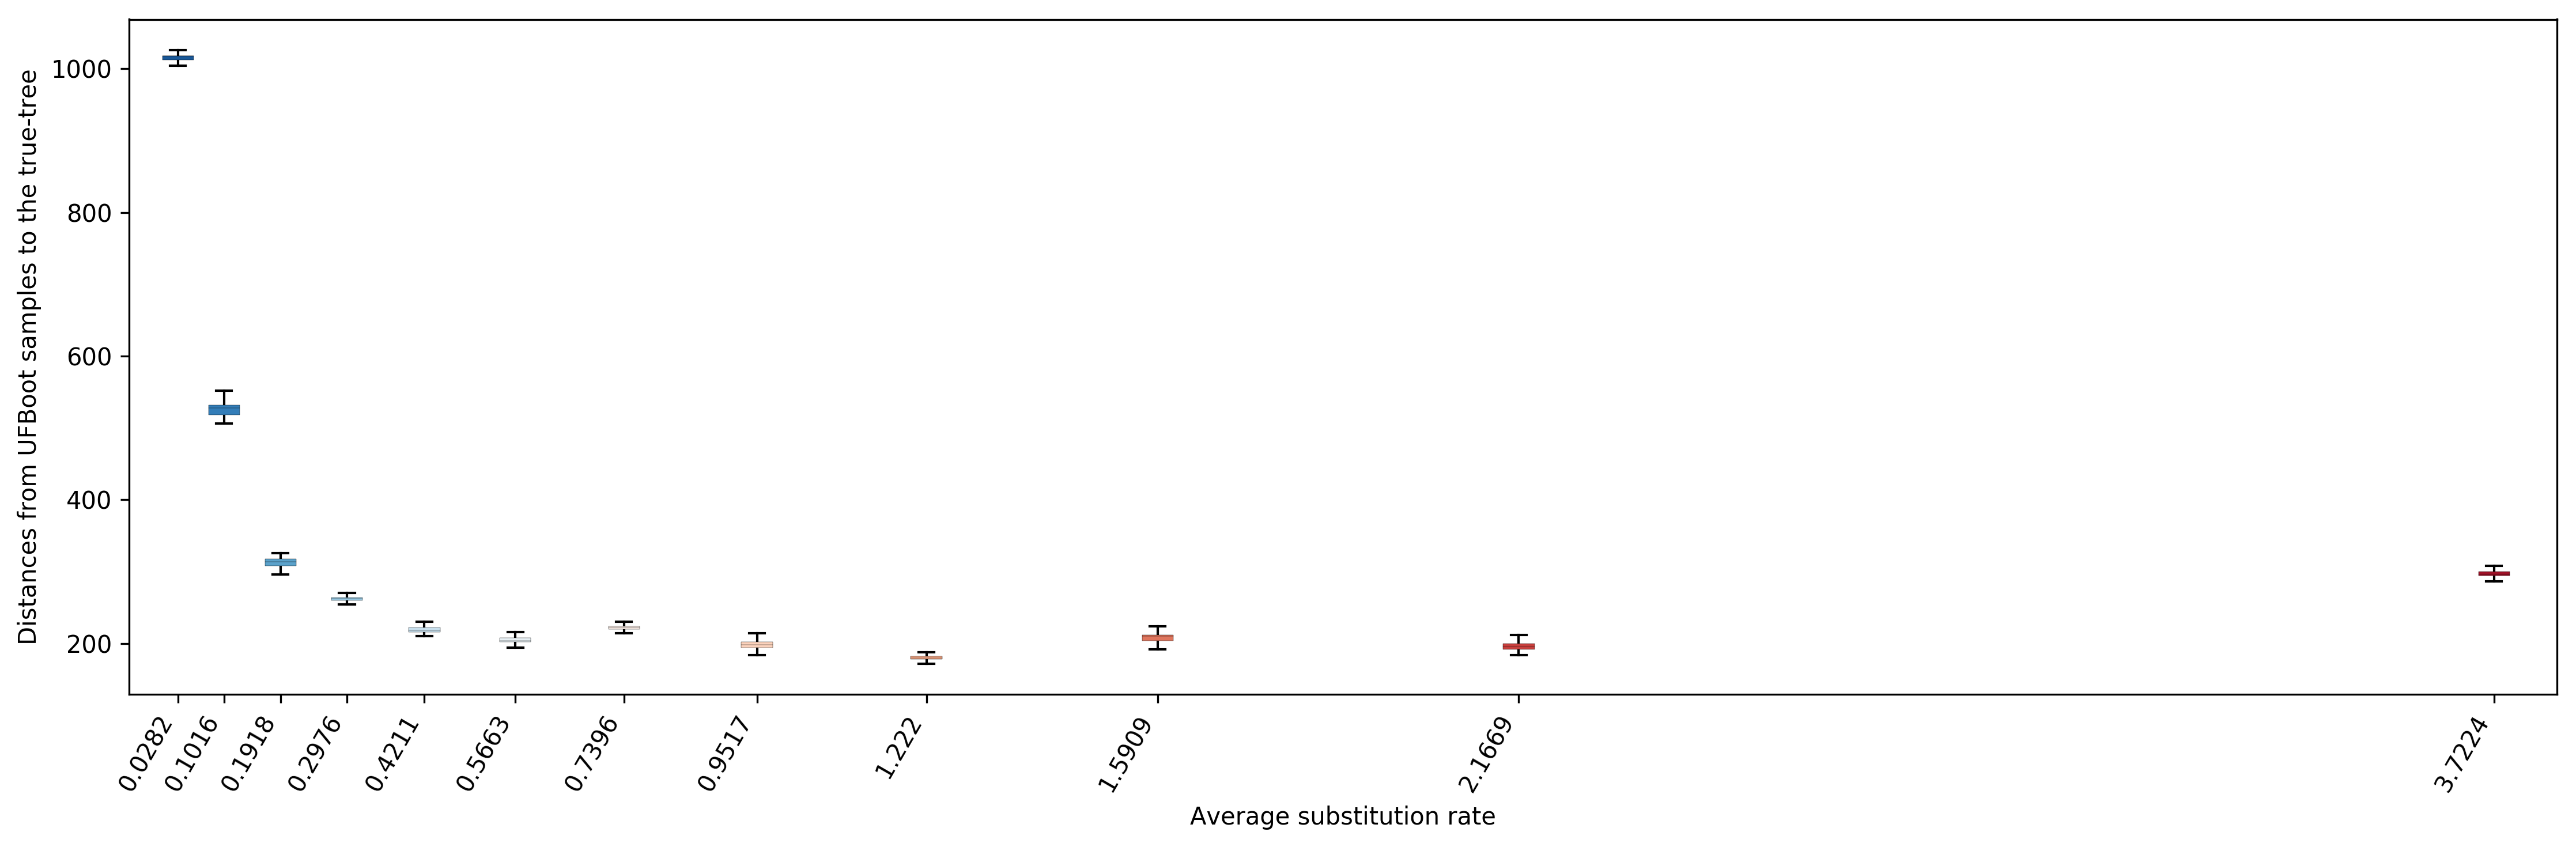

In [14]:
%cd /work/site_rate/sequence_simulation/hug/dayhoff/categories/rf
random.seed(12345)
fig, axs = plt.subplots(dpi=300, figsize=(15,5))

replicate = 1
distances = []
for category in range(1,13):
    iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
    iqtree_result.pop(0)
    distances.append([int(line.split()[1]) for line in iqtree_result])

rates     = pd.read_table('../../%i.rate' % replicate, comment='#')
rates.drop_duplicates('Cat', inplace=True)
rates.sort_values('Cat', inplace=True)

boxplot = axs.boxplot(distances, positions=rates.C_Rate.tolist(),
                     widths=0.05,
                     patch_artist=True,
                     showfliers=False,
                     boxprops={'linewidth':0.1},
                     whiskerprops={'linewidth':1},
                     medianprops={'linewidth':0.1,
                                  'color':'k'})
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)

axs.set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
axs.set_xlim(-0.05, rates.C_Rate.tolist()[-1]+0.1)
#axs.set_title('Replicate %i' % replicate)
axs.set_xlabel('Average substitution rate')
axs.set_ylabel('Distances from UFBoot samples to the true-tree')

fig.tight_layout()
fig.savefig('/Users/thiberio/Dropbox (MIT)/site_rates-paper/final figures/Figure S3.pdf')

In [3]:
%cd /work/site_rate/sequence_simulation/hug/dayhoff/categories/rf
random.seed(12345)
fig, axs = plt.subplots(dpi=200, figsize=(10,300), nrows=100)
ax_counter = -1
median_rfs   = []
median_rates = []
for replicate in range(1, 101):
#    print(replicate)
    if not all(os.path.isfile('%i.%i.rfdist' % (replicate, category)) 
               for category in range(1, 13)):
#        print('\tmissing one of the categories')
        continue

    ax_counter += 1
    distances = []
    for category in range(1,13):
        iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
        iqtree_result.pop(0)
        distances.append([int(line.split()[1]) for line in iqtree_result])
    
    rates     = pd.read_table('../../%i.rate' % replicate, comment='#')
    rates.drop_duplicates('Cat', inplace=True)
    rates.sort_values('Cat', inplace=True)

    boxplot = axs[ax_counter].boxplot(distances, positions=rates.C_Rate.tolist(),
                         widths=0.05,
                         patch_artist=True,
                         showfliers=False,
                         boxprops={'linewidth':0.1},
                         whiskerprops={'linewidth':1},
                         medianprops={'linewidth':0.1,
                                      'color':'k'})
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    
    axs[ax_counter].set_xticklabels([round(n, 4) for n in rates.C_Rate.tolist()], rotation=60, ha='right')
    axs[ax_counter].set_xlim(-0.05, rates.C_Rate.tolist()[-1]+0.1)
    axs[ax_counter].set_title('Replicate %i' % replicate)
fig.tight_layout()

/work/site_rate/sequence_simulation/hug/dayhoff/categories/rf


In [4]:
#%cd /work/site_rate/sequence_simulation/hug/dayhoff/rf
random.seed(12345)
slopes = []
pvals = []
rhos = []
for replicate in range(1, 101):
    if not all(os.path.isfile('%i.%i.rfdist' % (replicate, category)) 
               for category in range(1, 13)):
        print('%i\n\tmissing one of the categories' % replicate)
        continue
    distances = []
    for category in range(1,13):
        iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
        iqtree_result.pop(0)
        distances.append([int(line.split()[1]) for line in iqtree_result])
    
    rates     = pd.read_table('../../%i.rate' % replicate, comment='#')
    rates.drop_duplicates('Cat', inplace=True)
    rates.sort_values('Cat', inplace=True)

    x = rates.C_Rate.tolist()[-4:]
    y = [np.median(n) for n in distances[-4:]]
#    slopes.append(linregress(x,y).slope)
    regression = linregress(x,y)
    slopes.append(regression.slope)
    pvals.append(regression.pvalue)
    rhos.append(regression.rvalue)

In [6]:
pvals = np.asarray(pvals)
rhos  = np.asarray(rhos)
slopes  = np.asarray(slopes)

In [5]:
np.mean(slopes), np.std(slopes)

(31.67613185350746, 9.744279621941404)

In [10]:
slopes[pvals <= 0.05].mean(), slopes[pvals <= 0.05].std()

(35.19611248864209, 7.464550076383356)

In [8]:
rhos[pvals <= 0.05].mean()

0.977413683577751

In [7]:
pvals[pvals <= 0.05].shape

(47,)

In [19]:
ttest_ind(dayhoff, lg)

Ttest_indResult(statistic=121.536397753836, pvalue=0.0)

In [23]:
pvalues = {cat:[] for cat in range(1,13)}
tstats  = {cat:[] for cat in range(1,13)}
for replicate in range(1,101):
    dayhoff_distances = []
    for category in range(1,13):
        iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
        iqtree_result.pop(0)
        dayhoff_distances.append([int(line.split()[1]) for line in iqtree_result])
    
    with cd('/work/site_rate/sequence_simulation/hug/categories/rf/'):
        lg_distances = []
        for category in range(1,13):
            iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
            iqtree_result.pop(0)
            lg_distances.append([int(line.split()[1]) for line in iqtree_result])

    for dayhoff, lg, category in zip(dayhoff_distances, lg_distances, range(1,13)):
        tmp_t = ttest_ind(dayhoff, lg)
        tstats[category].append( tmp_t.statistic)
        pvalues[category].append(tmp_t.pvalue)

for category in range(1, 13):
    pvalues[category] = np.asarray(pvalues[category])
    tstats[ category] = np.asarray(tstats[ category])

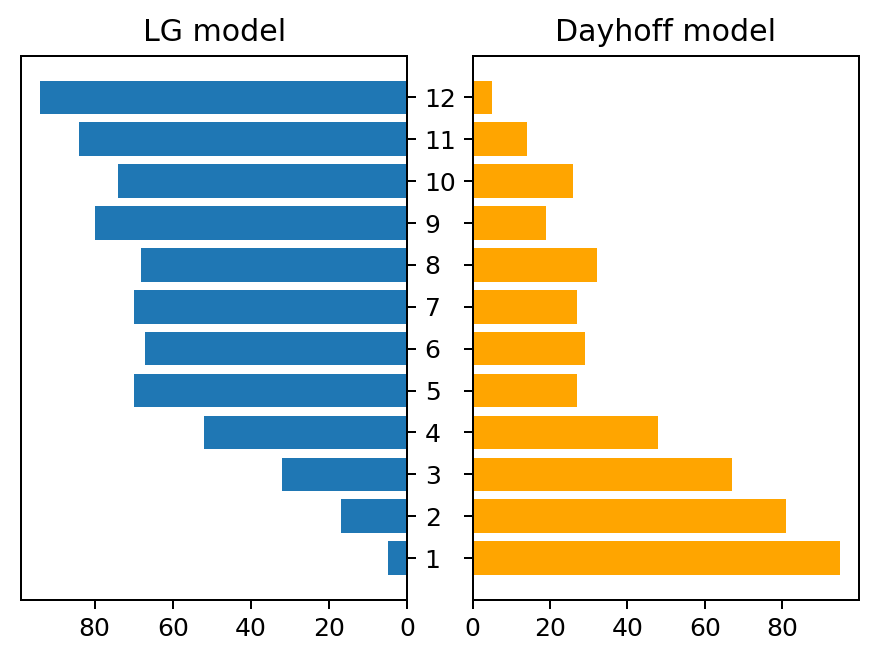

In [106]:
values_ax1 = []
values_ax2 = []
for category in range(1, 13):
    rejected, corrected, alphaSidak, alphaBonf = multipletests(pvalues[category])
    rejected_values = tstats[category][rejected]
    values_ax1.append(rejected_values[rejected_values > 0].shape[0])
    values_ax2.append(rejected_values[rejected_values < 0].shape[0])
#    print(category,
#          rejected_values[rejected_values > 0].shape[0],
#          rejected_values[rejected_values < 0].shape[0])

fig, axs = plt.subplots(ncols=2, dpi=180, sharey=True)
axs[0].barh(range(1,13), values_ax1)
axs[1].barh(range(1,13), values_ax2, color='orange')

axs[0].set_title('LG model')
axs[1].set_title('Dayhoff model')

axs[0].invert_xaxis()
axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[0].yaxis.tick_right()
plt.yticks(range(1,13))

fig.subplots_adjust(wspace=.17)
#fig.tight_layout()

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


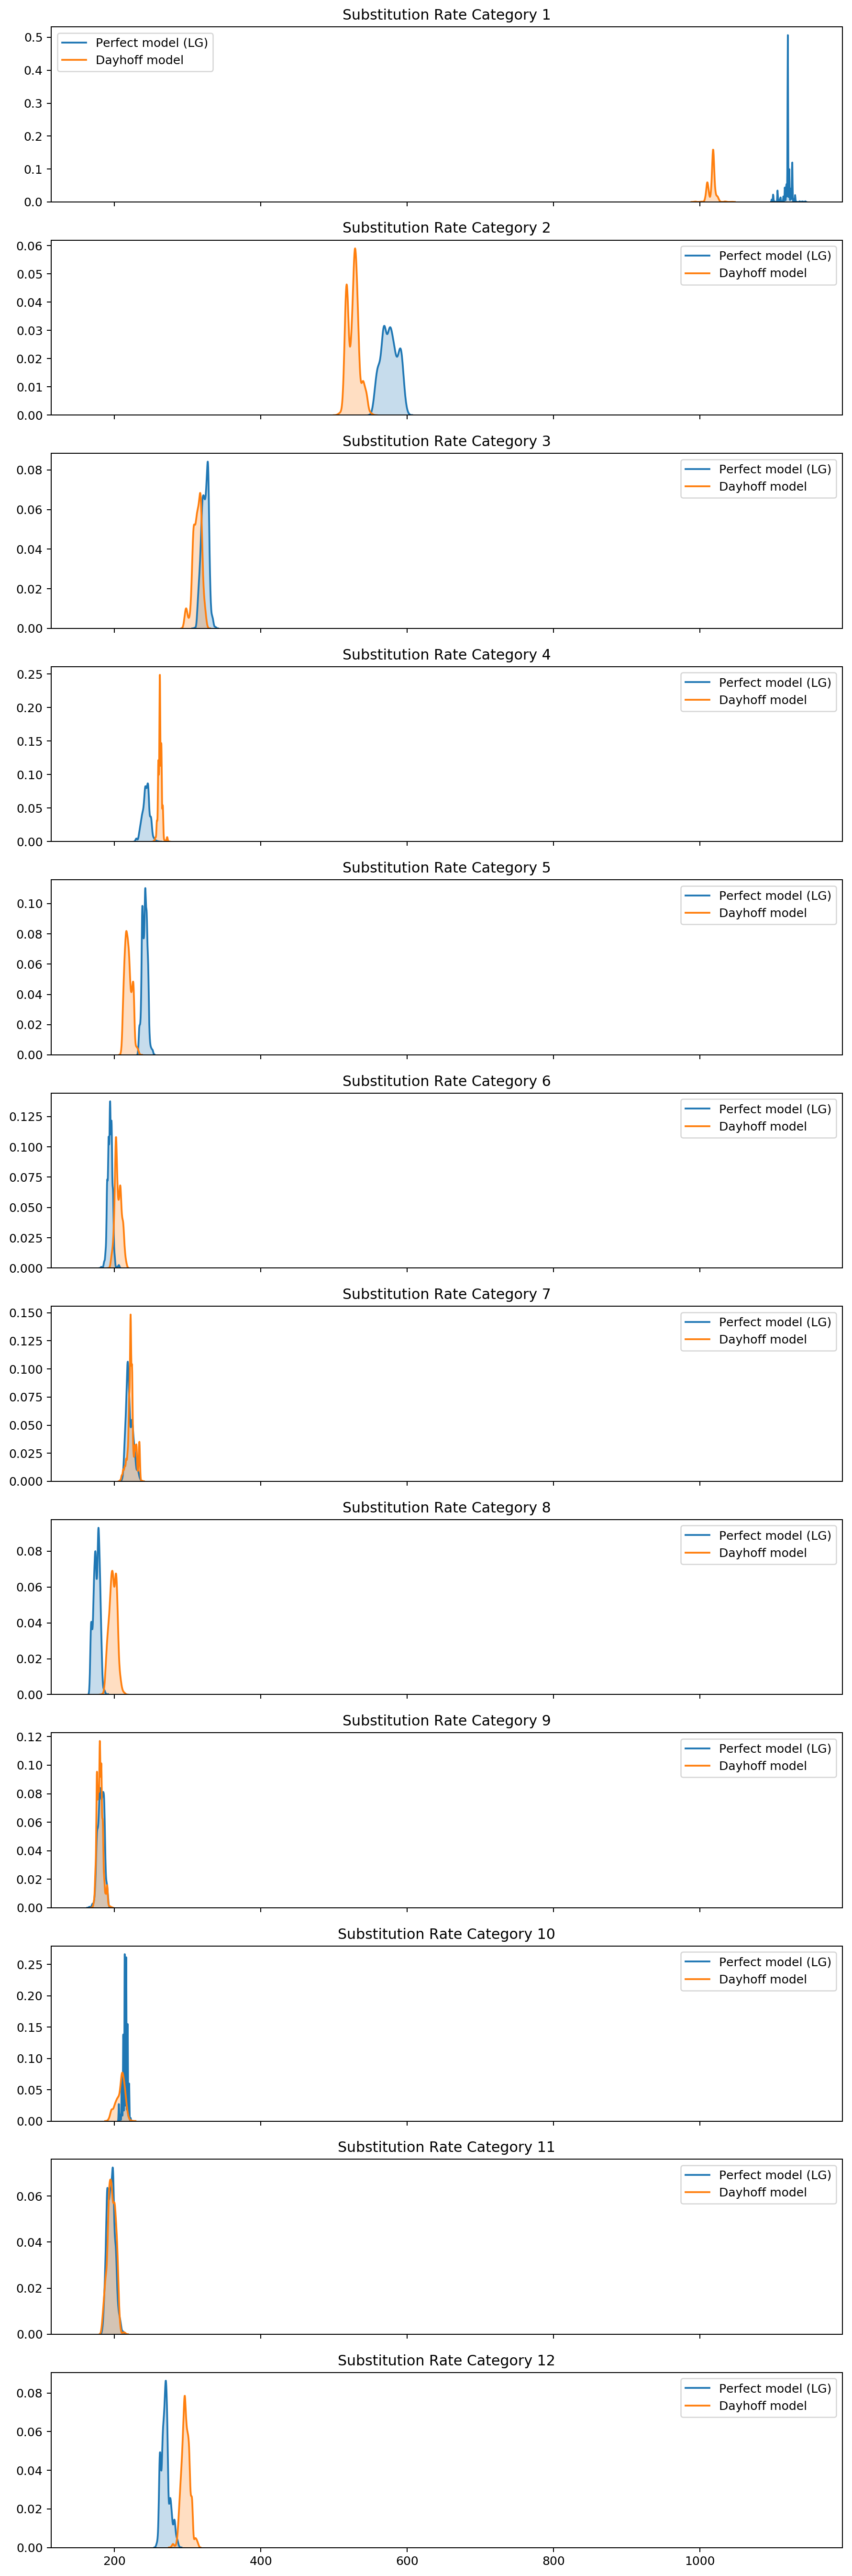

In [31]:
for replicate in range(1,101):
    dayhoff_distances = []
    for category in range(1,13):
        iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
        iqtree_result.pop(0)
        dayhoff_distances.append([int(line.split()[1]) for line in iqtree_result])
    
    with cd('/work/site_rate/sequence_simulation/hug/categories/rf/'):
        lg_distances = []
        for category in range(1,13):
            iqtree_result = open('%i.%i.rfdist' % (replicate, category)).readlines()
            iqtree_result.pop(0)
            lg_distances.append([int(line.split()[1]) for line in iqtree_result])

    fig, axs = plt.subplots(nrows=12, dpi=180, figsize=(10,30), sharex=True)
    counter = 1
    for dayhoff, lg, ax in zip(dayhoff_distances, lg_distances, axs):
        ax.set_title('Substitution Rate Category %i' % counter)
        sns.kdeplot(lg,      shade=True, ax=ax, label='Perfect model (LG)')
        sns.kdeplot(dayhoff, shade=True, ax=ax, label='Dayhoff model')
        counter += 1
    fig.tight_layout()
    break